In [ ]:
# reference: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

import pandas as pd
import json


dir='/Users/xinwang/ai/dataset/kaggle/GStore/'

def load_df(filename, nrows=None):
    JSON_COLUMNS = ['device','geoNetwork','totals','trafficSource']
    
    df = pd.read_csv(dir+filename, converters = {column: json.loads for column in JSON_COLUMNS},
                    dtype={'fullVisitorId':'str'},
                    nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = pd.io.json.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        print('load col', column)
        
    print(f"Loaded" ,filename," shape", df.shape, df.columns)
    
    return df

train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [ ]:
train_df.T.head(100)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

gdf = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf['totals.transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [ ]:
nzi = pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr = (gdf['totals.transactionRevenue']>0).sum()

print(nzi,train_df.shape[0],100*(nzi/train_df.shape[0]))
print(nzr,gdf.shape[0],100*(nzi/gdf.shape[0]))

In [ ]:
print(train_df.fullVisitorId.nunique(), train_df.shape[0])
print(test_df.fullVisitorId.nunique(), test_df.shape[0])

print(len(
    set(train_df.fullVisitorId.unique())
    .intersection(
        set(test_df.fullVisitorId.unique()))))


In [ ]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1]
print('constant columns',const_cols)

train_df.drop(columns=const_cols, inplace=True)
test_df.drop(columns=const_cols, inplace=True)


In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

excluded_browsers = ["Nokia","NokiaE52-1","SeaMonkey","Opera","Puffin","Nintendo","Reddit","Nichrome",
                     "(not","Mozilla","Seznam","TCL","ThumbSniper","UC","User","YE","YaBrowser",
                     "[Use","no-ua","osee2unifiedRelease","Mozilla","MQQBrowser","Maxthon","DoCoMo","ADM",
                     "Android","Apple-iPhone7C2","BlackBerry","CSM","Changa","Coc","DASH_JR_3G","HTC802t_TD",
                     "MRCHROME","Hisense","IE","Iron","Konqueror","LYF_LS_4002_11","LYF_LS_4002_12","Lunascape",
                     "M5","0","subjectAgent:"]

def merge_some_similar_browser(x):
    x = x.replace("Safari (in-app)","Safari")
    x = x.replace("Apple-iPhone7C2","Safari")
    x = x.replace("Android Browser","Android Webview")
    x = x.replace("Opera Mini","Opera")
    x = x.replace("Mozilla Compatible Agent","Firefox")
    x = x.replace("Mozilla","Firefox")
    
    x = x.replace("MRCHROME","Chrome")
    
    if x in excluded_browsers:
        return 'Excluded'
    
    return x
    
train_df['device.browser'] = train_df['device.browser'].apply(merge_some_similar_browser)
test_df['device.browser'] = test_df['device.browser'].apply(merge_some_similar_browser)

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(x=cnt_srs.values[::-1],
                  y=cnt_srs.index[::-1],
                  showlegend=False,
                  orientation='h',
                  marker=dict(color=color))
    return trace

## Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(50,171,96,0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgb(50,171,96,0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgb(50,171,96,0.6)')



## Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)
trace4 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(71,58,131,0.8)')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000), 'rgb(71,58,131,0.8)')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(1000), 'rgb(71,58,131,0.8)')


# device.operatingSystem
def merge_some_similar_operatingSystem(x):
    x = x.replace("Windows Phone","Windows")
    x = x.replace("Samsung","Android")
    
    return x
    
train_df['device.operatingSystem'] = train_df['device.operatingSystem'].apply(merge_some_similar_operatingSystem)
test_df['device.operatingSystem'] = test_df['device.operatingSystem'].apply(merge_some_similar_operatingSystem)

cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace7 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(81,68,131,0.8)')
trace8 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000), 'rgb(81,68,131,0.8)')
trace9 = horizontal_bar_chart(cnt_srs['mean'].head(1000), 'rgb(81,68,131,0.8)')


fig = plotly.tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,
                         subplot_titles=['Browser -count','Browser -non-zero revenue count','Browser -revenue mean',
                                        'deviceCategory -count','deviceCategory -non-zero revenue count','deviceCategory -mean'
                                        ])
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)

fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,2)
fig.append_trace(trace6,2,3)

fig.append_trace(trace7,3,1)
fig.append_trace(trace8,3,2)
fig.append_trace(trace9,3,3)


fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title='Device plots')
# py.iplot(fig)

In [ ]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(x=cnt_srs.index[::-1],
                      y=cnt_srs.values[::-1],
                      showlegend=False,
                      marker=dict(color=color))
    return trace

train_df['date_str'] = train_df['date'].astype(str)
test_df['date_str'] = test_df['date'].astype(str)
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]),
                                                                 int(str(x)[4:6]),
                                                                 int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size','count'])
cnt_srs.columns = ['count','count of non-zero revenue']

cnt_srs = cnt_srs.sort_index()

trace1 = scatter_plot(cnt_srs['count'],'red')
trace2 = scatter_plot(cnt_srs['count of non-zero revenue'],'blue')

fig = plotly.tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                                subplot_titles=['Date -count','Date -non-zero revenue count'])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
    
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title='Date plots')
py.iplot(fig, filename='Date plots')

In [ ]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), 
                                                                int(str(x)[4:6]), 
                                                                int(str(x)[6:])))

cnt_srs = test_df.groupby('date')['fullVisitorId'].agg(['size'])

trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(height=400, width=800, paper_bgcolor='rgb(233,233,233)',title='Dates in Test set')

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Date In test file')

In [ ]:
# geoNetwork.continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(1000),'rgba(58,71,80,0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgba(58,71,80,0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgba(58,71,80,0.6)')


# geoNetwork.subContinent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(1000),'rgba(98,71,80,0.6)')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgba(98,71,80,0.6)')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgba(98,71,80,0.6)')


# geoNetwork.networkDomain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace7 = horizontal_bar_chart(cnt_srs['count'].head(100),'rgba(128,71,80,0.6)')
trace8 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(100),'rgba(128,71,80,0.6)')
trace9 = horizontal_bar_chart(cnt_srs['mean'].head(100),'rgba(128,71,80,0.6)')


fig = plotly.tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.05,
                                subplot_titles=['continent count','continent non-zero count','continent mean revenue',
                                               'subContinent count','subContinent non-zero count','subContinent mean revenue',
                                               'networkDomain count','networkDomain non-zero count','networkDomain mean revenue'])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title='Geo plots')
py.iplot(fig, filename='geo plots')

In [ ]:
# trafficSource.source
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'green')

# trafficSource.medium
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(10), 'purple')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'purple')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'purple')


fig = plotly.tools.make_subplots(rows=2, cols=3, vertical_spacing=0.07, horizontal_spacing=0.08,
                                subplot_titles=['trafficSource count','trafficSource non-zero count','trafficSource revenue mean',
                                               'trafficSource medium count','trafficSource medium non-zero count','trafficSource medium revenue mean'])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)


fig['layout'].update(height=1000,width=1200, paper_bgcolor='rgb(233,233,233)', title='Traffic Source plots')
py.iplot(fig, filename='trafficeSource plots')

In [ ]:
# totals.pageviews
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(100), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(100), 'cyan')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(100), 'cyan')

# hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(60), 'blue')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(60), 'blue')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(60), 'blue')

fig = plotly.tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.08,
                                subplot_titles=['pageviews count','pageviews non-zero revenue count','pageviews mean',
                                               'hits count','hits non-zero revenue count','hits mean'])


fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)

fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,2)
fig.append_trace(trace6,2,3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title='Visitor profile plots')

py.iplot(fig, filename='visitor-profile-plots')

In [ ]:
train_df.drop(columns=['trafficSource.campaignCode'], axis=1, inplace=True)
# test_df.drop(columns=['trafficSource.campaignCode'], axis=1, inplace=True)

print(train_df.columns.values)

In [ ]:
import re

def get_networdDomain_suffix(x):
    suffix = str(x).split('.')[-1]

    suffix = suffix.replace("\\032","")

    if re.search('[a-zA-Z]', str(x)):
        return suffix
    else:
        return ""

def get_networdDomain_prefix(x):
    prefix = str(x).split('.')[0]

    if re.search('[a-zA-Z]', str(x)):
        return prefix
    else:
        return ""


def merge_some_similar_networkDomain(x):
    x = str(x).replace("(not set)","unknown.unknown")
    
    return x

def process_networkDomain(df):
    df['networdDomain_suffix'] = df['geoNetwork.networkDomain'].apply(get_networdDomain_suffix)
    df['networdDomain_prefix'] = df['geoNetwork.networkDomain'].apply(get_networdDomain_prefix)
    df['geoNetwork.networkDomain'] = df['geoNetwork.networkDomain'].apply(merge_some_similar_networkDomain)
    
    return df
    
train_df = process_networkDomain(train_df)
test_df = process_networkDomain(test_df)
print('process_networkDomain done, train_df.shape',train_df.shape)

def merge_adContent(x):
    if str(x).find('KeyWord')>=0:
        x = x.split(":")[1]
        x = x.replace("}","")
        x = x.replace("?","")
        
        return x
    elif str(x).find("Ad from")>=0 or str(x).find('Ad created')>=0:
        return "Ad from"
    
    return x
        
def merge_campaign(x):
    if str(x).find('AW')>=0:
        return 1
    elif str(x).find('Data Share')>=0:
        return 2
    else:
        return 3

def keyword_merge(x):
    if str(x).lower().find("store")>=0 or str(x).lower().find("shop")>=0:
        return "google store"
    elif str(x).lower().find('merchandise')>=0 or str(x).lower().find('merch')>=0:
        return "merchandise"
    elif str(x).lower().find('tube')>=0:
        return "youtube"
    elif str(x).lower().find('shirt')>=0:
        return "shirt"
    elif str(x).lower().find('targeting')>=0:
        return "targeting"
    else:
        if len(str(x).lower().split(' '))>1:
            x = str(x).lower().split(' ')[1]
        else:
            x = str(x).lower()
               
        x = x.replace('+','')
        return x

def referralPath_language(x):
    if str(x).find('/yt/about')>=0:
        x = str(x)[10:]
        x = x.split('/')[0]
        return x
    
    return 'unknown'

def referralPath_prefix(x):
    array = str(x).split('/')
    if len(array)>1:
        return array[1]
    
    return x
        
def source_suffix(x):
    if str(x).find('.com')>=0:
        return 'com'
    elif str(x).find('.')>=0:
        return str(x).split('.')[-1]
    
    return x

def source_prefix(x):
    if str(x).find('.')>=0:
        return str(x).split('.')[0]
    
    return x
        
def process_trafficSource(df):
    df["trafficSource.adContent"] = df["trafficSource.adContent"].apply(merge_adContent)
    df["campaign_merge"] = df["trafficSource.campaign"].apply(merge_campaign)

    df["keyword_merge"] = df["trafficSource.keyword"].apply(keyword_merge)
    df["referralPath_language"] = df["trafficSource.referralPath"].apply(referralPath_language)
    
    df["referralPath_prefix"] = df["trafficSource.referralPath"].apply(referralPath_prefix)
    df["source_suffix"] = df["trafficSource.source"].apply(source_suffix)

    df["source_prefix"] = df["trafficSource.source"].apply(source_prefix)
    
    return df
    
train_df = process_trafficSource(train_df)
test_df = process_trafficSource(test_df)
print('process_trafficSource done, train_df.shape',train_df.shape)


In [ ]:
from sklearn.preprocessing import LabelEncoder


train_df['totals.transactionRevenue'].fillna(0, inplace=True)

cate_columns = ['channelGrouping',
                'device.browser','device.deviceCategory','device.operatingSystem',"device.isMobile",
                'geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.metro',
                'geoNetwork.networkDomain','geoNetwork.region','geoNetwork.subContinent',
                'trafficSource.adContent','trafficSource.adwordsClickInfo.adNetworkType',
                'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.isVideoAd',
                'trafficSource.adwordsClickInfo.slot',
                'trafficSource.campaign','trafficSource.isTrueDirect','trafficSource.keyword',
                'networdDomain_suffix','networdDomain_prefix','campaign_merge','keyword_merge',
                'trafficSource.medium','referralPath_language','referralPath_prefix','source_suffix']


label = LabelEncoder()
def label_transform(df, col_list):
    for col in col_list:
        df[col] = label.fit_transform(df[col])

    return df

for col in cate_columns:
    print(col,' fit transform...')
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) +
           list(test_df[col].values.astype('str')))
    
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    

numeric_columns = ['totals.bounces','totals.hits','totals.newVisits',
                   'totals.pageviews','visitNumber',
                   'visitStartTime','trafficSource.adwordsClickInfo.page']
for col in numeric_columns:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    print('numeric column', col)


In [ ]:
print(cate_columns)

In [ ]:
##################datetime##################
date_cate_features = ['year','month','day','week','weekofyear','dayofweek','quarter','month_start','month_end']

def process_datetime(df):
    df['datetime'] = pd.to_datetime(df['date_str'], format='%Y%m%d',errors='ignore')
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['month'] =df['month'].astype(int)
    
    df['day'] = df['datetime'].dt.day
    df['day'] = df['day'].astype(int)

    df['week'] = df['datetime'].dt.week
    df['week'] = df['week'].astype(int)
    
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekofyear'] = df['weekofyear'].astype(int)
    
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofweek'] = df['dayofweek'].astype(int)
    
    df['quarter'] = df['datetime'].dt.quarter
    df['quarter'] = df['quarter'].astype(int)
    
    df['month_start'] = df['day'].apply(lambda x: 1 if x<=7 else 0).astype(int)
    df['month_end'] = df['day'].apply(lambda x: 1 if x>=25 else 0).astype(int)

    df = label_transform(df, date_cate_features)
    
    return df

train_df = process_datetime(train_df)
test_df = process_datetime(test_df)
cate_columns += date_cate_features

print('process_datetime done')

###################################### 
last_time_features = ['last_seconds','last_minutes']

def process_last_time(df):
    df['last_seconds'] = df['visitStartTime']-df['visitId']
    df['last_minutes'] = (df['visitStartTime']-df['visitId'])/60
    df['last_minutes'] = df['last_minutes'].astype(np.int64)

    return df

train_df = process_last_time(train_df)
test_df = process_last_time(test_df)
numeric_columns += last_time_features
print('process_last_time done')

In [ ]:
day_seconds = 24 * 60* 60
month_seconds = 30 * day_seconds
debug=False

transaction_features = ['days_from_last_visted','months_from_last_visted','max_visit_number',
                        'sum_previous_pageviews','log1p_pageviews','mean_pageviews','median_pageviews',
                        'has_pageviews','sum_previous_hits','sum_hits','has_hits','mean_hits','median_hits',
                        'transaction_count']
numeric_columns += transaction_features


#################### Parallel run  #################### 
import tqdm

#CreateFeature the seconds from last visited
def create_feature_times_from_last_visited(group_df):
    days_from_last_array = []
    months_from_last_array = []
    
    visitId_array = group_df['visitId'].values
    last = visitId_array[0]
    for item in group_df['visitId'].values:
        days = int((item-last)/day_seconds)
        days_from_last_array.append(days)
        
        months = int((item-last)/month_seconds)
        months_from_last_array.append(months)
        
        last = item
        
        
    group_df['days_from_last_visted'] = days_from_last_array
    group_df['months_from_last_visted'] = months_from_last_array
    
    return group_df
    
def create_feature_max_visit_number(group_df):
    max_visit_num = np.max(group_df['visitNumber'])
    
    group_df['max_visit_number'] = [max_visit_num]*group_df.shape[0]
    
    return group_df

def create_feature_previous_sum_pageviews(group_df):
    sum_previous_pageviews = []
    sum = 0
    for item in group_df['totals.pageviews'].values:
        sum += item
        sum_previous_pageviews.append(sum)
            
    group_df['sum_previous_pageviews'] = sum_previous_pageviews
    
    return group_df

def create_feature_log1p_pageviews(group_df):
    log1p_pageviews = []
    for item in group_df['totals.pageviews'].values:
        log1p_pageviews.append(np.log1p(item))
            
    group_df['log1p_pageviews'] = log1p_pageviews
    
    return group_df

def create_feature_mean_pageviews(group_df):
    mean_pageviews = np.mean(group_df['totals.pageviews'].values)
    group_df['mean_pageviews'] = [mean_pageviews]*group_df.shape[0]
    
    return group_df

def create_feature_median_pageviews(group_df):
    median_pageviews = np.median(group_df['totals.pageviews'].values)
    group_df['median_pageviews'] = [median_pageviews]*group_df.shape[0]
    
    return group_df


def create_feature_has_pageviews(group_df):
    has_pageviews = (group_df['totals.pageviews']>0).sum()
    group_df['has_pageviews'] = [has_pageviews]*group_df.shape[0]
    
    return group_df
    
def create_feature_previous_sum_hits(group_df):
    sum_previous_hits = []
    sum = 0
    for item in group_df['totals.hits'].values:
        sum += item
        sum_previous_hits.append(sum)
            
    group_df['sum_previous_hits'] = sum_previous_hits
    
    return group_df

def create_feature_sum_hits(group_df):
    sum = 0
    for item in group_df['totals.hits'].values:
        sum += item
            
    group_df['sum_hits'] = [sum]*group_df.shape[0]
    
    return group_df

def create_feature_has_hits(group_df):
    has_hits = (group_df['totals.hits']>0).sum()
            
    group_df['has_hits'] = [has_hits]*group_df.shape[0]
    
    return group_df

def create_feature_mean_hits(group_df):
    mean_hits = np.mean(group_df['totals.hits'].values)
            
    group_df['mean_hits'] = [mean_hits]*group_df.shape[0]
    
    return group_df

def create_feature_median_hits(group_df):
    median_hits = np.median(group_df['totals.hits'])
            
    group_df['median_hits'] = [median_hits]*group_df.shape[0]
    
    return group_df
    
def create_feature_transaction_count(group_df):
    count = group_df.shape[0]
    
    group_df['transaction_count'] = [count] * group_df.shape[0]
    
    return group_df


import multiprocessing

def process_one_group(group_df):
    group_df = create_feature_times_from_last_visited(group_df)
    group_df = create_feature_max_visit_number(group_df)
    
#   pageviews
    group_df = create_feature_previous_sum_pageviews(group_df)
#   hits
    group_df = create_feature_previous_sum_hits(group_df)
#   transcation count
    group_df = create_feature_transaction_count(group_df)
    
    group_df = create_feature_log1p_pageviews(group_df)
    group_df = create_feature_mean_pageviews(group_df)
    group_df = create_feature_median_pageviews(group_df)
    group_df = create_feature_has_pageviews(group_df)
    
    group_df = create_feature_sum_hits(group_df)
    group_df = create_feature_has_hits(group_df)
    group_df = create_feature_mean_hits(group_df)
    group_df = create_feature_median_hits(group_df)

    return group_df
    

def parallel_batch_process_groups(grouped):
    print('Run parallel_batch_process_groups')
    
    batch = []
    first_batch=True
    result_df = pd.DataFrame()

    counter = 0
    total = len(grouped.size())
    for name, group_df in grouped:
        group_df_copy = group_df.copy()
        
        fullVisitorId = group_df_copy['fullVisitorId'].values[0]

        group_df_copy.sort_values(by='visitNumber', inplace=True)
        group_df_copy = process_one_group(group_df_copy)

        batch.append(group_df_copy)
        counter += 1
        del group_df_copy
        
        if len(batch)>=5000:
            print('progress report', multiprocessing.current_process().name,100.0*(counter/total))
            if first_batch is True:
                result_df = pd.concat(batch, axis=0)
                del batch
                batch = []
                first_batch = False
            else:
                batch_df = pd.concat(batch, axis=0)
                result_df = pd.concat([result_df, batch_df], axis=0)
                del batch
                del batch_df
                batch = []
        
    batch_df = pd.concat(batch, axis=0)
    
    if result_df.shape[0]>0:
        result_df = pd.concat([result_df, batch_df], axis=0)
    else:
        result_df = batch_df
    del batch
    del batch_df
            
    return result_df
    

def applyParallelInBatch(df, by_field, func):
    df_copy = df.copy()
    
    batch_size=8
    
    df_copy['hash_index'] = df_copy[by_field].apply(lambda x: hash(x) % batch_size)
    
    pool = multiprocessing.Pool(processes=batch_size)
    
    batch_result = []
    for i in range(batch_size):
        batch_df = df_copy[df_copy['hash_index'] == i]
        grouped = batch_df.groupby(by_field)
        
        batch_result.append(pool.apply_async(func, args=(grouped,)))
        print('apply async job to pool',batch_df.shape)
#         nee to check
        del batch_df 
        
    print()
    print()
    pool.close()
    pool.join()
    
    result_df = pd.DataFrame(columns=df.columns)
    for i in batch_result:
        part_df = i.get()
        result_df = pd.concat([result_df,part_df], axis=0)
        print('got result result_df',result_df.shape)
        
        del part_df
            
    del df_copy
    return result_df


def process_transactions(df):
    print('Parallel run applyParallelInBatch')
    input_columns = ['fullVisitorId','visitId','visitNumber','totals.pageviews','totals.hits']
    transaction_df = applyParallelInBatch(df[['sessionId'] + input_columns ],
                                          'fullVisitorId',
                                          parallel_batch_process_groups)
    transaction_df.drop(input_columns, axis=1, inplace=True)

    print('should have', len(df['fullVisitorId'].unique()))
    print('transaction_df.shape',transaction_df.shape)

    df = pd.merge(df,transaction_df, on='sessionId', how='left')

    del transaction_df
    
    return df
    
train_df = process_transactions(train_df)
test_df = process_transactions(test_df)

print('process_transactions done')
print('train.shape',train_df.shape)
print('test.shape',test_df.shape)

In [ ]:
print(numeric_columns)

train_df[cate_columns+numeric_columns]= train_df[cate_columns+numeric_columns].fillna(0)
test_df[cate_columns+numeric_columns]= test_df[cate_columns+numeric_columns].fillna(0)


In [ ]:
################################Add feature*feature ###########################################
# https://www.kaggle.com/safavieh/ultimate-feature-engineering-xgb-lgb-nn
Corr = {}

import time
import pylab as pl
from scipy.stats import pearsonr
import gc


train_df['target'] = np.log1p(train_df['totals.transactionRevenue'].values)

train_df['tr']=1
train_df['ts']=0
test_df['tr']=0
test_df['ts']=1

all_df = pd.concat((train_df, test_df))
all_df_copy = all_df[numeric_columns + ['tr','ts','target']].copy()

x_train = all_df[all_df.tr==1]
y_train = x_train['target'].values

n=4

inx=[pl.randint(0, x_train.shape[0], int(x_train.shape[0]/n)) for k in range(n)]
print(inx[0])

print('start process polynomial features', len(numeric_columns))

for i, c in enumerate(numeric_columns):
    start_time = time.time()
    
    C1,P1 = pl.nanmean([pearsonr(y_train[inx[k]], (1+x_train[c].iloc[inx[k]])) for k in range(n)], 0)
    C2,P2 = pl.nanmean([pearsonr(y_train[inx[k]], 1/(1+x_train[c].iloc[inx[k]])) for k in range(n)], 0)
    
    if P2<P1:
        all_df_copy[c] = 1/(1+all_df_copy[c])
        Corr[c] = [C2,P2]
    else:
        all_df_copy[c] = 1 + all_df_copy[c]
        Corr[c] = [C1,P1]
        
    end_time = time.time()
    print('calculate corr',c,'cost time', (end_time-start_time))

print('corr size', len(Corr))
        
polyCol = []
thrP = 0.01
thrC =0.02

for i, c1 in enumerate(numeric_columns):
    C1,P1 = Corr[c1]
    
    start_time = time.time()
    
    for c2 in numeric_columns[i+1:]:
        C2,P2 = Corr[c2]
        V = all_df_copy[c1] * all_df_copy[c2]
        Vtrain = V[all_df_copy.tr==1].values
        
        C,P = pl.nanmean([pearsonr(y_train[inx[k]], Vtrain[inx[k]]) for k in range(n)],0)
        
        if (P<thrP) and (abs(C)-max(abs(C1), abs(C2)))>thrC:
            all_df_copy[c1+'_'+c2+'_poly'] = V
            train_df[c1+'_'+c2+'_poly'] = train_df[c1] * train_df[c2]
            test_df[c1+'_'+c2+'_poly'] = test_df[c1] * train_df[c2]
            
            polyCol.append(c1+'_'+c2+'_poly')
            print('find new feature',c1+'_'+c2+'_poly', len(polyCol))
        else:
            del V,Vtrain
    
    end_time = time.time()
    print('poly feature progress',str(i),'cost time',(end_time-start_time),'s')
        
del x_train, y_train,all_df_copy,all_df
gc.collect()

numeric_columns += polyCol

numeric_columns = list(set(numeric_columns))
cate_columns = list(set(cate_columns))


print('len numeric_columns',len(numeric_columns))

print('cate_columns len',len(cate_columns), cate_columns)
print()
print('numeric_columns len',len(numeric_columns),numeric_columns)

In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt

def rebalance(df):
    df_positive =df[df['totals.transactionRevenue']>0]
    df_negative =df[df['totals.transactionRevenue']<=0]

    removed = df_negative.shape[0] - df_positive.shape[0]
    
    if removed>0:
        df_negative = df_negative[removed:]
        
    print('df_positive', df_positive.shape[0], 'df_negative', df_negative.shape[0])
    return pd.concat((df_positive,df_negative), axis=0)

def train_and_split(cate_features, numeric_features, seed=1234, classify=False, stardard=False):
    train_df_copy = train_df.copy()
    
    dev_df = train_df_copy.sample(frac=0.8, random_state=seed)
    val_df = train_df_copy.drop(dev_df.index)
    
    if classify is True:
        dev_df = rebalance(dev_df)
        val_df = rebalance(val_df)
        
        dev_y = dev_df['totals.transactionRevenue'].apply(lambda x: 1 if x>0 else 0).values
        val_y = val_df['totals.transactionRevenue'].apply(lambda x: 1 if x>0 else 0).values
    else:
        dev_y = np.log1p(dev_df['totals.transactionRevenue'].values)
        val_y = np.log1p(val_df['totals.transactionRevenue'].values)
    
    print(dev_df.shape,val_df.shape,train_df_copy.shape)

    dev_x = dev_df[cate_features + numeric_features]
    val_x = val_df[cate_features + numeric_features]
    
    if stardard is True:
        scaler = StandardScaler()
        dev_x = scaler.fit_transform(dev_x)
        val_x = scaler.fit_transform(val_x)
        
    del train_df_copy
    return dev_x, val_x, dev_y, val_y
    

print('wangxin')

In [ ]:
################################ RandomForestClassifier ########################################### 
from sklearn.ensemble import RandomForestClassifier

def add_RandomForest_feature(epochs=1):
    randomForest = RandomForestClassifier(n_estimators=5000, max_features=10,max_depth=5,
                                          min_samples_split=2,bootstrap=True,
                                          random_state=1234,warm_start=True,n_jobs=8, 
                                          verbose=False)
    scores = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(cate_columns, numeric_columns, seed=i*100 +1, classify=True)
        randomForest.fit(dev_x, dev_y)
        
        predict_y = randomForest.predict(val_x)
        
        auc = metrics.roc_auc_score(val_y,predict_y)
        scores.append(auc)

        del dev_x, val_x, dev_y, val_y
        
    print('final auc',np.mean(scores), scores)
    
    rf_train_prediction = randomForest.predict_proba(train_df[cate_columns + numeric_columns])
    rf_test_prediction = randomForest.predict_proba(test_df[cate_columns + numeric_columns])

    print('len rf_train_prediction', len(rf_train_prediction), 'train_df shape',train_df.shape)
    train_df['randomForest_prediction'] = np.array(rf_train_prediction)[:,0]
    test_df['randomForest_prediction'] = np.array(rf_test_prediction)[:,0]

    numeric_columns.append('randomForest_prediction')
        
add_RandomForest_feature(epochs=3)

In [ ]:
################################ XGB Classifier ########################################### 
from xgboost import XGBClassifier


def add_xgb_classifier_feature(epochs=1):
    xgb_classifier_model = XGBClassifier(learning_rate=0.01, n_estimators=100, gamma=0, subsample=0.8, 
                                         eval_metric='auc', max_depth=10, colsample_bytree=0.8, seed=1234)
    
    scores = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(cate_columns, numeric_columns, seed=i*100 +1, classify=True)
        xgb_classifier_model.fit(dev_x, dev_y, eval_set=[(dev_x, dev_y),(val_x, val_y)], 
                                 eval_metric='auc', verbose=True)
        print('XGBoost fit over')
        predict_y = xgb_classifier_model.predict(val_x)
        print('xgb classiifier predict_y', predict_y[0:10])

        auc = metrics.roc_auc_score(val_y,predict_y)
        scores.append(auc)
        print('XGBoost',i, auc,scores)

        del dev_x, val_x, dev_y, val_y

    print('final XGB score', np.mean(scores), scores)
    xgb_train_prediction = xgb_classifier_model.predict_proba(train_df[cate_columns + numeric_columns])
    xgb_test_prediction = xgb_classifier_model.predict_proba(test_df[cate_columns + numeric_columns])

    train_df['xgb_prediction'] = np.array(xgb_train_prediction)[:,0]
    test_df['xgb_prediction'] = np.array(xgb_test_prediction)[:,0]

    numeric_columns.append('xgb_prediction')

        
add_xgb_classifier_feature(3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 37, 20)       2000000     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 37, 20)       0           embedding_2[0][0]                
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 740)          0           spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
input_4 (I

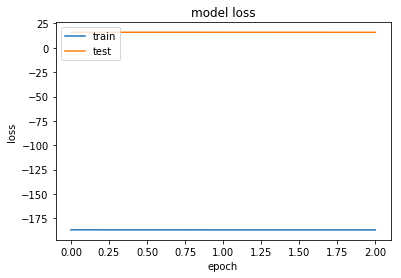

In [45]:
####################**************NN*************************########################################
####################**************Discard*************************########################################
from keras.layers import Input, Dense, concatenate, Dropout, Embedding, Flatten, SpatialDropout1D
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras import losses
import tensorflow as tf


def extra_lmse(y_true, y_pred, e=0.1):
    return tf.sqrt(losses.mean_squared_error(y_true,y_pred))

def plot_metric(history):
    # summarize history for accuracy
    plt.figure(figsize=(12,10))
    plt.plot(history.history['extra_lmse'])
    plt.plot(history.history['val_extra_lmse'])
    plt.title('model lmse')
    plt.ylabel('extra_lmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_losses(histroy):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def reblance_input():
    df = train_df
        
    df_copy = df.copy()
    df_copy = rebalance(df_copy)
    
    print('after reblance',df_copy.shape)
    
    return df_copy
    

def get_NN_model():
    input_cate = Input((len(cate_columns),))
    input_numeric = Input((len(numeric_columns),))
    
    bias_init = initializers.RandomUniform(minval=-0.005, maxval=0.005, seed=1234)
    
    x_cate = Embedding(100000, 20, embeddings_initializer='uniform',
                       embeddings_regularizer=regularizers.l2(0.0001))(input_cate)
    x_cate = SpatialDropout1D(0.2)(x_cate)
    x_cate = Flatten()(x_cate)
    x_cate = Dropout(0.2)(x_cate)
    x_cate = Dense(100,activation='tanh',kernel_regularizer=regularizers.l2(0.0001),
                   bias_initializer=bias_init,kernel_initializer='uniform')(x_cate)
    
    x_numeric = Dense(100, activation='tanh', kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer='uniform',
                      bias_initializer=bias_init)(input_numeric)
    x_numeric = Dropout(0.2)(x_numeric)

    x = concatenate([x_cate, x_numeric])
    x = Dense(100, activation='tanh', kernel_regularizer=regularizers.l2(0.0001),
              kernel_initializer='uniform',bias_initializer=bias_init)(x)
    
    output = Dense(1, kernel_initializer = 'normal')(x)
    
    model = Model(inputs=[input_cate, input_numeric], outputs=output)
    model.compile(optimizer=optimizers.Adam(), loss=extra_lmse, metrics=[extra_lmse])
    
    return model


def run_nn_model():
    nn_model = get_NN_model()
    print(nn_model.summary())

    reblance_train = reblance_input()
    history = nn_model.fit([reblance_train[cate_columns], reblance_train[numeric_columns]], reblance_train['target'], validation_split=0.3,
             epochs=3, batch_size=10)

    # nn_prediction = nn_model.predict([test_df[cate_columns], test_df[numeric_columns]] , batch_size=10)
    # submit_to_csv(nn_prediction, 'nn_model')

    plot_losses(history)

In [28]:
numeric_columns = list(set(numeric_columns))
cate_columns = list(set(cate_columns))
test_x = test_df[cate_columns + numeric_columns]


def build_submission_df(prediction):
    sub_df = pd.DataFrame({'fullVisitorId':test_df['fullVisitorId'].values})
    prediction[prediction<0] = 0 
    print('sub_df.shape',sub_df.shape)

    sub_df['PredictedLogRevenue'] = np.expm1(prediction)

    sub_df = sub_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
    sub_df.columns = ['fullVisitorId','PredictedLogRevenue']

    sub_df['PredictedLogRevenue'] = np.log1p(sub_df['PredictedLogRevenue'])

    return sub_df
    

def submit_to_csv(prediction, model_name='default_model_name'):
    print('test_x.shape',test_x.shape,'prediction len', len(prediction))
    
    sub_df = build_submission_df(prediction)
    
    sub_df.to_csv(model_name +'_xgb_base.csv', index=False)

    print('predict done')

def rmse(y_actual, y_predict):
    return sqrt(mean_squared_error(y_actual, y_predict))
    
print('pass')

pass


In [26]:
################################ GradientBoostingRegressor ########################################### 

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=0.8, 
                                criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None,
                                max_features=None, alpha=0.9, verbose=1, max_leaf_nodes=None, 
                                warm_start=False, presort='auto',
                                random_state=1234,)
def train_and_valid(cate_features, numeric_features,epochs = 5):
    array = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(cate_features, numeric_features,seed=i*100 +1)

        model = gbr.fit(dev_x, dev_y)
        predict = model.predict(val_x)

        metric_value = rmse(val_y,predict)
        print('gbr ',i,' predict metric rmse', metric_value)
        array.append(metric_value)
        del dev_x, val_x, dev_y, val_y
        
    print('final mean rmse', np.mean(array))
    return model
    
gbr_model = train_and_valid(cate_columns, numeric_columns,epochs=1)

gbr_predict = gbr_model.predict(test_df[cate_columns + numeric_columns])

submit_to_csv(gbr_predict, 'GradientBoostRegressor')
print('gbr done')

(724359, 86) (181090, 86) (905449, 86)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           3.7716           0.2420            3.79m
         2           3.5963           0.1935            3.72m
         3           3.4426           0.1520            3.72m
         4           3.2839           0.1311            3.74m
         5           3.1716           0.1064            3.71m
         6           3.0950           0.0852            3.67m
         7           3.0179           0.0699            3.66m
         8           2.9777           0.0576            3.63m
         9           2.9294           0.0461            3.61m
        10           2.8853           0.0350            3.57m
        20           2.6905           0.0109            3.19m
        30           2.6461           0.0012            2.74m
        40           2.6238           0.0017            2.32m
        50           2.6029           0.0020            1.95m
        60           2.5847   

(724359, 86) (181090, 86) (905449, 86)
xgb  0  predict metric rmse 1.703653613581047
final mean rmse 1.703653613581047


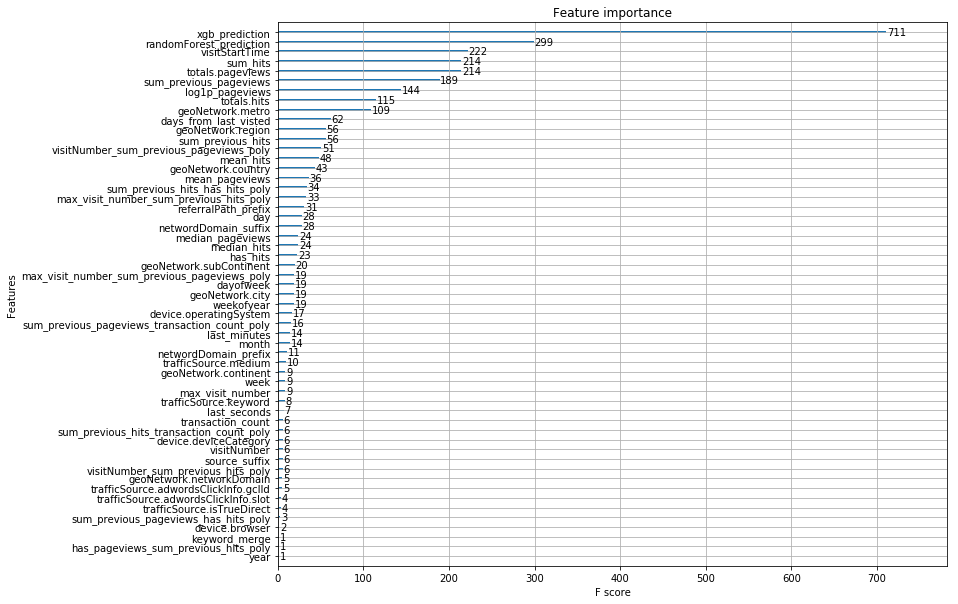

In [27]:
######################## XGBoost train ####################################################
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.8, eval_metric='rmse',
                       max_depth=5,colsample_bytree=0.8, silent=False, seed=1234)

def train_and_valid(cate_features, numeric_features,epochs = 5):
    array = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(cate_features, numeric_features,seed=i*100 +1)

        model = xgb_regressor.fit(dev_x, dev_y)
        predict = model.predict(val_x)

        metric_value = rmse(val_y,predict)
        print('xgb ',i,' predict metric rmse', metric_value)
        array.append(metric_value)
        del dev_x, val_x, dev_y, val_y
        
    print('final mean rmse', np.mean(array))
    return model
    
xgb_model = train_and_valid(cate_columns, numeric_columns,epochs=1)

from xgboost import plot_importance
import matplotlib.pyplot as plt

ax = plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches(12,10)
plt.show()

37 [0.23114434 0.09720416 0.07217165 0.06957087 0.06144343 0.04681404
 0.03738622 0.03543563 0.02015605 0.01820546 0.01657997 0.01560468
 0.01397919 0.01170351 0.01105332 0.01072822 0.01007802 0.00910273
 0.00780234 0.00747724 0.00650195 0.00617685 0.00552666 0.00520156
 0.00455137 0.00357607 0.00325098 0.00292588 0.00260078 0.00227568
 0.00195059 0.00162549 0.00130039 0.00097529 0.0006502  0.0003251
 0.        ]
(724359, 86) (181090, 86) (905449, 86)
dev_x (724359, 72) val_x (181090, 72)
select_x_train.shape (724359, 1) select_x_valid.shape (181090, 1)
xgb select  0.23114434  predict metric rmse 1.7258539591329154 cost time 13.325656175613403 s
dev_x (724359, 72) val_x (181090, 72)
select_x_train.shape (724359, 7) select_x_valid.shape (181090, 7)
xgb select  0.046814043  predict metric rmse 1.7144177232105355 cost time 39.04311180114746 s
dev_x (724359, 72) val_x (181090, 72)
select_x_train.shape (724359, 13) select_x_valid.shape (181090, 13)
xgb select  0.016579974  predict metric rm

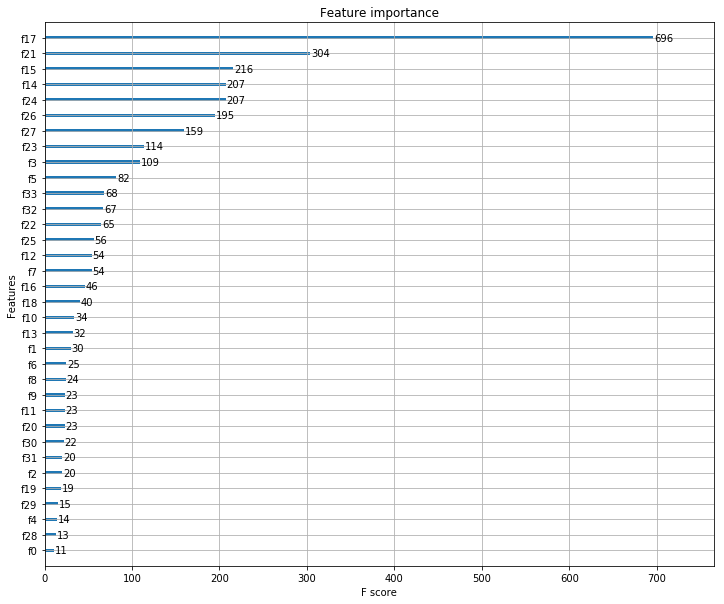

In [29]:
######################## Best features train ####################################################
from sklearn.feature_selection import SelectFromModel

thresholds = np.sort(list(set(xgb_model.feature_importances_)))[::-1]
print(len(thresholds),thresholds)

dev_x, val_x, dev_y, val_y = train_and_split(cate_columns, numeric_columns,seed=i*100 +1)

best_model=xgb_model
best_metric = 1000
best_selection = SelectFromModel(xgb_model, threshold=0, prefit=True)
for i, thresh in enumerate(thresholds):
    if i%5 != 0:
        continue
        
    start_time = time.time()
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    
    print('dev_x',dev_x.shape,'val_x',val_x.shape)
    select_x_train = selection.transform(dev_x)
    select_x_valid = selection.transform(val_x)

    print('select_x_train.shape',select_x_train.shape,'select_x_valid.shape',select_x_valid.shape)
    
    
    xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.8, eval_metric='rmse',
                       max_depth=5,colsample_bytree=0.8, silent=False, seed=1234)
    select_model = xgb_regressor.fit(select_x_train,dev_y)
    predict_y = select_model.predict(select_x_valid)
    
    metric_value = rmse(val_y,predict_y)
    print('xgb select ',thresh,' predict metric rmse', metric_value,'cost time',(time.time()-start_time),'s')
    del select_x_train,select_x_valid
    
    if metric_value<best_metric:
        best_metric = metric_value
        best_model = select_model
        best_selection = selection
        
ax = plot_importance(best_model)
fig = ax.figure
fig.set_size_inches(12,10)
plt.show()


In [ ]:
print(train_df.columns.values)
print(len(test_df['fullVisitorId'].values))

################################ XGBoost Predict ########################################################
selection_test_x = best_selection.transform(test_x)
xgb_predict = best_model.predict(selection_test_x)

submit_to_csv(predict_test)

In [43]:
########################### LR Stacking  ###########################
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True, normalize=False, copy_X=False, n_jobs=8)

def get_multip_regressions_df(x,y=None):
    gbr_predict = gbr_model.predict(x)
    xgb_predict = best_model.predict(best_selection.transform(x))

    predict_df = pd.DataFrame({
        'gbr_predict':gbr_predict,
        'xgb_predict':xgb_predict,
        'target':y
    })

    return predict_df

def train_and_valid(cate_features, numeric_features,epochs = 3):
    scores = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(cate_features, numeric_features,seed=i*100 +1)

        predict_df = get_multip_regressions_df(dev_x,dev_y)
        lr.fit(predict_df[['gbr_predict','xgb_predict']], predict_df['target'])

        predict_val_df = get_multip_regressions_df(val_x,val_y)
        lr_val_predict = lr.predict(predict_val_df[['gbr_predict','xgb_predict']])

        metric_value = rmse(val_y,lr_val_predict)
        scores.append(metric_value)
        print('lr predict rmse ', metric_value, scores)

        del predict_df,predict_val_df
        del dev_x, val_x, dev_y, val_y
        
    print('final LR mean rmse', np.mean(scores))

    return lr
    
LR_model = train_and_valid(cate_columns, numeric_columns,epochs=2)


test_predict_df = get_multip_regressions_df(test_x)
lr_prediction = LR_model.predict(test_predict_df[['gbr_predict','xgb_predict']])

submit_to_csv(lr_prediction, 'LinearRegression')

(724359, 86) (181090, 86) (905449, 86)
lr predict rmse  1.6315050284477264 [1.6315050284477264]
(724359, 86) (181090, 86) (905449, 86)
lr predict rmse  1.5883770553143417 [1.6315050284477264, 1.5883770553143417]
final LR mean rmse 1.609941041881034
test_x.shape (806326, 72) prediction len 806326
sub_df.shape (806326, 1)
predict done
